In [144]:
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt 

In [145]:
class NBC: 

    # initialise class variables
    def __init__(self, feature_types, num_classes, name="not declared"):
        self.feature_types = feature_types
        self.num_features = len(feature_types)
        self.num_classes = num_classes
        self.name = name 

    # get values for Nc and pic (number of cs and probability of seeing a c)
    def count_pi(self, y): 
        self.N  = np.zeros(self.num_classes)
        self.pi = np.zeros(self.num_classes) 
        for c in range(self.num_classes): 
            self.N[c] += 1
        self.pi = self.N / len(y)
        
    # calculate the mean and variance for each feature, separated by each class
    def parameters(self, X, y): 
        self.count_pi(y) 
        mean = []
        var = []
        for c in range(self.num_classes):
            mean.append(sum(X[i] for i in range(len(X)) if y[i] == c) / self.N[c])
            var.append(sum(X[i]**2 for i in range(len(X)) if y[i] == c) / self.N[c] - np.power(mean[c], 2))
        self.mean = np.asarray(mean)
        self.var = np.asarray(var)

    # return the gaussian likelihood given a mean, variance and x
    def gaussian(self, mean, var, x): 
        return (-0.5*np.log( 2*(np.pi)*var) - 0.5 * ((x - mean) / var)**2)

    # return the bernoulli likelihood given a probability and an x
    def bernoulli(self, m, x):
        return -(x*np.log(m) + (1-x) * np.log(1-m))

    # predict a value for c for a given datapoint, by iterating over possible values and picking the most likely
    # uses gaussian / bernoulli depending on the feature type 
    def guess_c(self, x):
        max_p = -100000
        max_c = 0
        for c in range(self.num_classes):
            total_prob = np.log(self.pi[c])
            for f in range(len(x)): 
                mean = self.mean[c][f]
                var = self.var[c][f]
                if self.feature_types[f] == "r": total_prob += self.gaussian(mean, var, x[f])
                elif self.feature_types[f] == "b": total_prob += self.bernoulli(mean, x[f])
            if total_prob > max_p: 
                max_p = total_prob
                max_c = c
        return max_c 
            

    # calculate parameters 
    def fit(self, X, y):
        self.parameters(X,y)

    # generate predictions for a test set
    def predict(self, Xtest):
        yhat = np.zeros(len(Xtest))
        for x in range(len(Xtest)):
            yhat[x] = self.guess_c(Xtest[x])
        return yhat

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

# load iris data
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, shuffle=True)


# create model for irises and train
nbc = NBC(feature_types=["r", "r", "r", "r"], num_classes=3)
nbc.fit(X_train,y_train)

# generate predictions for irises 
y_pred = nbc.predict(X_test)

# plot confusion matrix and give an accuracy score for irises 
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
print("Confusion matrix:\n", cm)
print("\nAccuracy score:\n", ac)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, shuffle=True)

Confusion matrix:
 [[11  0  0]
 [13  0  0]
 [ 6  0  0]]

Accuracy score:
 0.36666666666666664


/tmp/ipykernel_7976/2215208150.py:31: RuntimeWarning: invalid value encountered in log
  return (-0.5*np.log( 2*(np.pi)*var) - 0.5 * ((x - mean) / var)**2)


In [147]:
# run sklearn's implementation of gaussian to check that it has the same results as mine (it does)
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred  =  classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
print("Confusion matrix:\n", cm)
print("\nAccuracy score:\n", ac)

Confusion matrix:
 [[11  0  0]
 [ 0 13  0]
 [ 0  1  5]]

Accuracy score:
 0.9666666666666667


In [148]:
# train logistic regression and print results 
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', C=10, random_state=0)
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test) 
cm = confusion_matrix(y_test, y_pred_lr)
ac = accuracy_score(y_test,y_pred_lr)
print("Confusion matrix:\n", cm)
print("\nAccuracy score:\n", ac)
g1 = GaussianNB()
g2 = GaussianNB()


Confusion matrix:
 [[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]

Accuracy score:
 1.0


In [149]:
# voting dataset
Xv, yv = cp.load(open('voting.pickle', 'rb'))

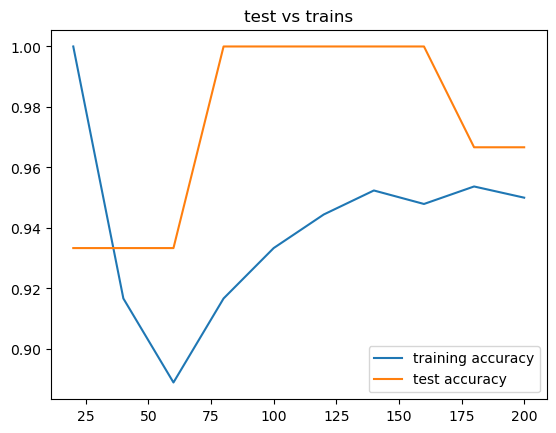

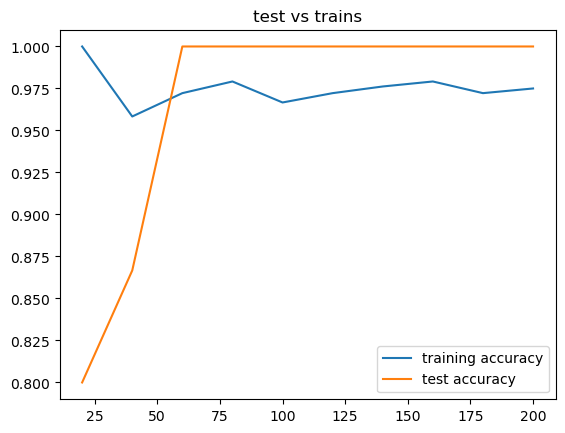

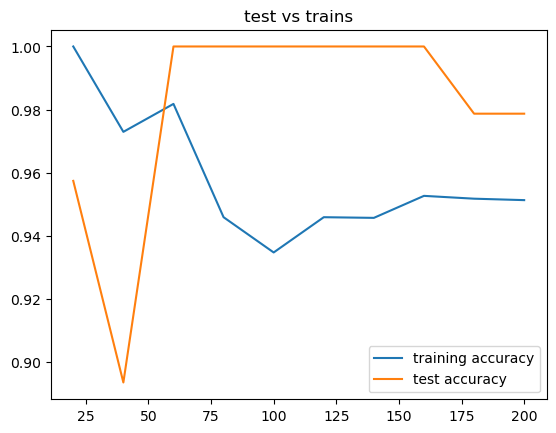

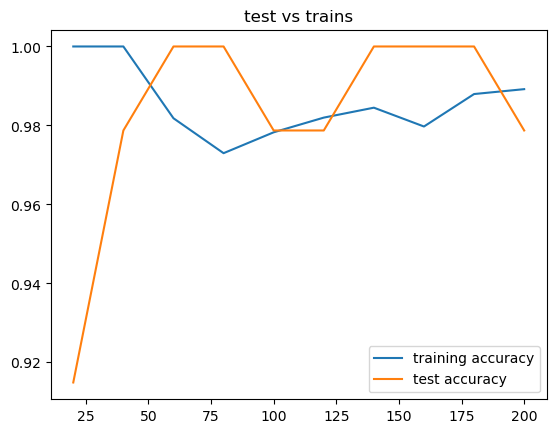

In [150]:
# train model on increasing amounts of data 

n1 = NBC(feature_types=["r", "r", "r", "r"], num_classes=3)
l1 = LogisticRegression(penalty='l2', C=10, random_state=0)
n2 = NBC(feature_types=["b"]*16, num_classes=2)
l2 = LogisticRegression(penalty='l2', C=10, random_state=0)

iris_data = X_train, X_test, y_train, y_test
voting_data = train_test_split(Xv, yv, test_size = 0.20, random_state = 0, shuffle=True)

models = [
    (g2, iris_data), 
    (l1, iris_data), 
    (g1, voting_data),
    (l2, voting_data)
    ]

repeats = 1

for (model, data) in models: 
    (X_train, X_test, y_train, y_test) = data 
    L_trains = np.zeros(10)
    L_tests = np.zeros(10) 
    for a in range(repeats): 
        for k in range(10): 
            i = int( ((k+1) / 10) * len(X_train) )
            X_train_n = X_train[:i]
            y_train_n = y_train[:i]

            model.fit(X_train_n, y_train_n)

            y_train_pred = model.predict(X_train_n)
            y_test_pred = model.predict(X_test)
            L_train = accuracy_score(y_train_n,y_train_pred)
            L_test = accuracy_score(y_test, y_test_pred) 

            L_trains[k] += (L_train) 
            L_tests[k] += (L_test)
    
    L_trains /= repeats
    L_tests /= repeats 
    
naive_bayes1
    n = np.arange(20, 220, 20)

    cm = confusion_matrix(y_test, y_test_pred)

    baseline = np.full(len(n), 0.4)

    plt.title("test vs trains")

    plt.plot(n, L_trains, label = "training accuracy")
    plt.plot(n, L_tests, label = "test accuracy")
    plt.plot()
    plt.legend()
    plt.show()